<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/analyze_gluc_trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install openpyxl
!pip install XlsxWriter
# !pip install pingouin
# !pip install CMH
# !pip install svgutils


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 kB 9.9 MB/s eta 0:00:00


In [3]:
import tifffile
import numpy as np
from google import colab
from matplotlib import pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib as mpl
import pandas as pd

In [4]:
def get_drobox_file(new_filename, link):
    !wget -o $new_filename $link
    return new_filename


In [5]:
def get_drobox_file(new_filename, link):
    !wget -O $new_filename $link
    return new_filename

link = 'https://www.dropbox.com/s/rm0kd1vl4sg5efg/Glucose%20data%20May2023.xlsx?dl=1'
new_filename = 'data.xlsx'
get_drobox_file(new_filename, link)
my_df_dict  = pd.read_excel('/content/data.xlsx',engine='openpyxl',header=[0,1,2,3],index_col=None,sheet_name=None) 

# Trim  blanks
for k,v in my_df_dict.items():
    v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
    for c in v.columns:
        if v[c].isnull().all():
            v=v.drop(c,axis=1)
    my_df_dict[k]=v
# display(v.head())

--2023-05-27 03:19:26--  https://www.dropbox.com/s/rm0kd1vl4sg5efg/Glucose%20data%20May2023.xlsx?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/rm0kd1vl4sg5efg/Glucose%20data%20May2023.xlsx [following]
--2023-05-27 03:19:26--  https://www.dropbox.com/s/dl/rm0kd1vl4sg5efg/Glucose%20data%20May2023.xlsx
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc422bebc29ebfc79ed8cf2d9027.dl.dropboxusercontent.com/cd/0/get/B80kbs9mXdDeUAgILvq2DrMwHE69QxBJztftreAgRQQScrfwyowBrLPYkjCJZFDWaz7luxq3IPToq2s4yHqIvwfA81Lzy16h-YJ6oO0KZBAU9DuU3haQ8budz01C96LG1s9hDMHKi0dsx0SANKmnULck5z4GIj6je-V9jgePopN__3YZzS0jzi2uv-aW5-5T-Z0/file?dl=1# [following]
--2023-05-27 03:19:27--  https://uc422bebc29ebfc79ed8cf2d9027.dl.dropboxusercontent.com/cd/0/get/B80kbs

<ipython-input-5-aeca254e218d>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
<ipython-input-5-aeca254e218d>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
<ipython-input-5-aeca254e218d>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
<ipython-input-5-aeca254e218d>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
<ipython-input-5-aeca254e218d>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axi

In [6]:
my_df_dict = dict([(k,v) for k,v in my_df_dict.items() if '22' in k])

In [7]:
from scipy.signal import butter,filtfilt
import scipy

def exp_func(xdata,a,b,c):
    return a*np.exp(xdata/-b) + c

def bleach_cor(trace,ref_inds,lpf=0.2,order=1):

    # b, a = butter(order, lpf, btype='lowpass')
    # trace_f = filtfilt(b, a, trace)
    trace_f = trace    
    good_ref = np.logical_not(np.isnan( trace_f[ref_inds]))
    ref_inds = ref_inds[good_ref]
    y_fittable = trace_f[ref_inds]
    p0= [np.max(trace), 20000, np.min(trace)]
    min_bound = [0,1000,0]
    max_bound = [np.max(trace)*2,np.inf,np.max(trace)*2]
    p = scipy.optimize.curve_fit(exp_func, ref_inds, y_fittable,p0=p0,bounds=(min_bound,max_bound))
    bleach_trace = exp_func(np.arange(len(trace)), p[0][0], p[0][1], p[0][2])
    trace_corr = trace/bleach_trace * (p[0][0]+p[0][2])
    return trace_corr, bleach_trace

def z_trans(y):
    return (y-np.nanmean(y))/np.nanstd(y)



In [8]:
def add_time(my_df_dict,basic_offset= -3.75, cam_rate =10):
    time_value_dict = {}
    for k,v in my_df_dict.items():
        df_val = v.copy()
        df_time = v.copy()
        for c in v.columns:
            # print(k,c)
            freq = int(c[1].replace('Hz',""))
            'Base Pclamp Timing'
            if 'LFP' in c[3] or 'PopSpike' in c[3] or 'fEPSP slope' in c[2]:
                pulse_t_ind = np.arange(np.sum(df_val[c].notnull()))
                pulse_t = pulse_t_ind.astype('float') * 1/freq
                for i in pulse_t_ind:
                    df_time.at[i,c] = pulse_t[i]

            if 'Glucose' in c[2]:
                df_time[c] = pd.Series((np.arange(len(df_val[c])))/cam_rate)
                is_dip = z_trans( df_val[c] ) < -5                
                pulse_ind = np.where(is_dip)[0]
                pulse_ind = [i for i in pulse_ind if i <2000]
                y_t = df_time[c][pulse_ind]
                pulse_time = np.mean(y_t)
                df_time[c] = pd.Series((np.arange(len(df_val[c])))/10) - pulse_time + basic_offset

        time_value_dict[k] = {'values':v,'time':df_time}
        
    return time_value_dict

time_value_dict = add_time(my_df_dict)

In [9]:
def upsample(y_low,fs_low,fs_high,x_low=[],x_high=[],kind='quadratic'):

    y_low_good = np.logical_not(np.isnan(y_low))
    y_low = y_low[y_low_good]
    x_low = x_low[y_low_good]
    # if np.sum(np.isnan(y_low))>0: print('NANS!')

    len_low = len(y_low)
    up_ratio = fs_high/fs_low

    if len(x_low)==0: x_low=np.arange(len_low)
    if len(x_high)==0: x_high=np.arange(np.min(x_low),np.max(x_low)+1/fs_low,1/fs_high)
    interpolator = scipy.interpolate.interp1d(x_low, y_low, kind=kind)

    x_in_range = np.logical_and(  x_high<np.max(x_low),x_high>np.min(x_low)  )
    x_high =x_high[x_in_range]

    y_high = interpolator(x_high)

    # print(np.max(x_low))
    # print(np.max(x_high))
    # print(len(y_low))
    # print(len(x_low))
    # print(len(x_high))
    # print(len(y_high))
    return y_high, x_high

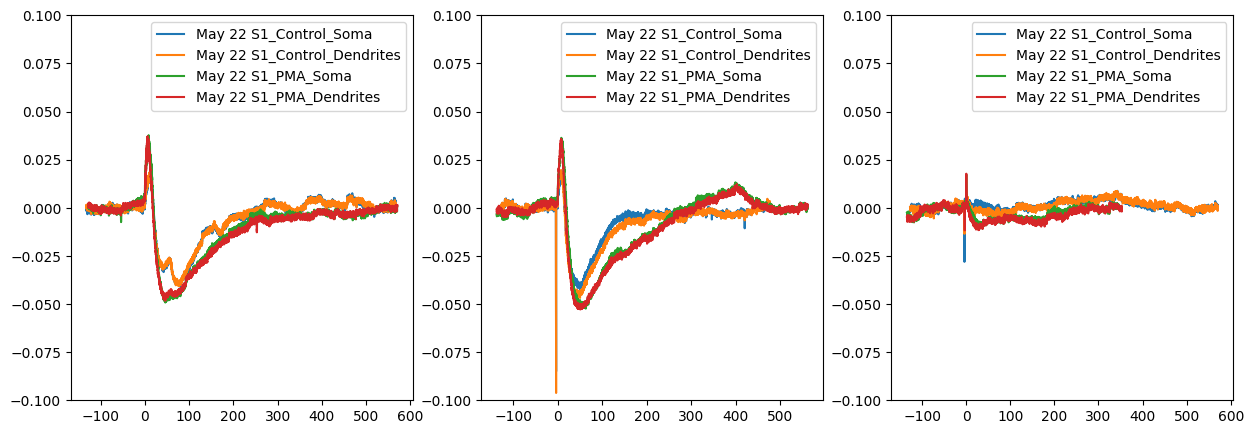

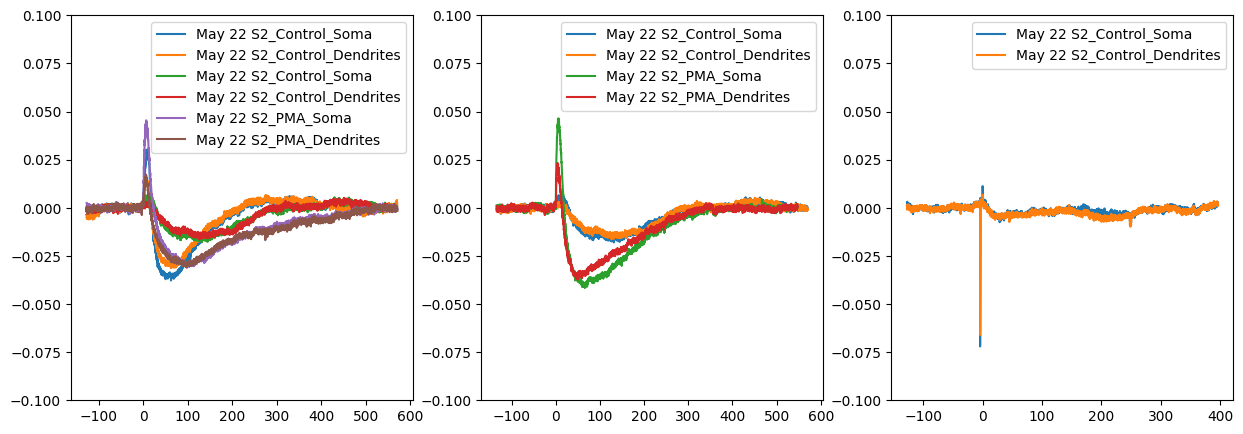

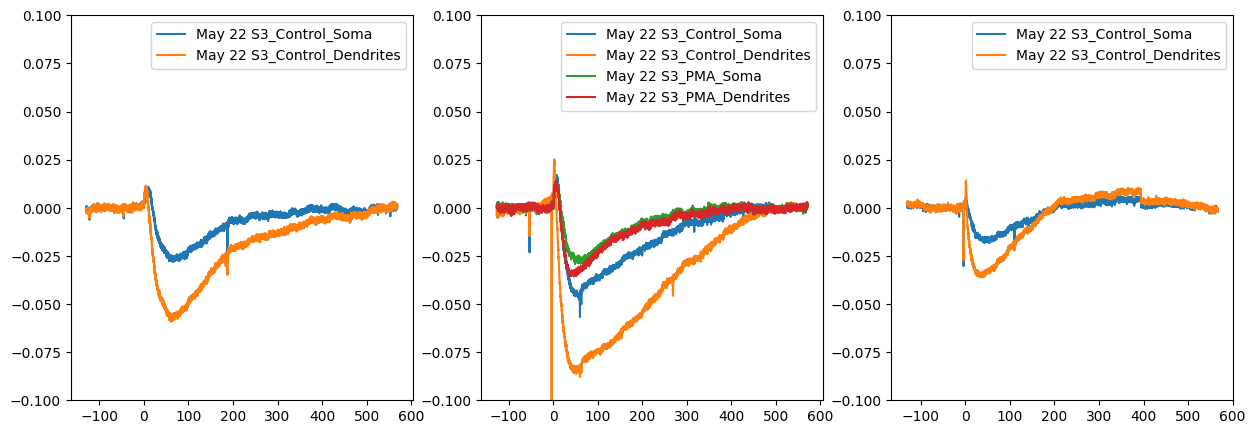

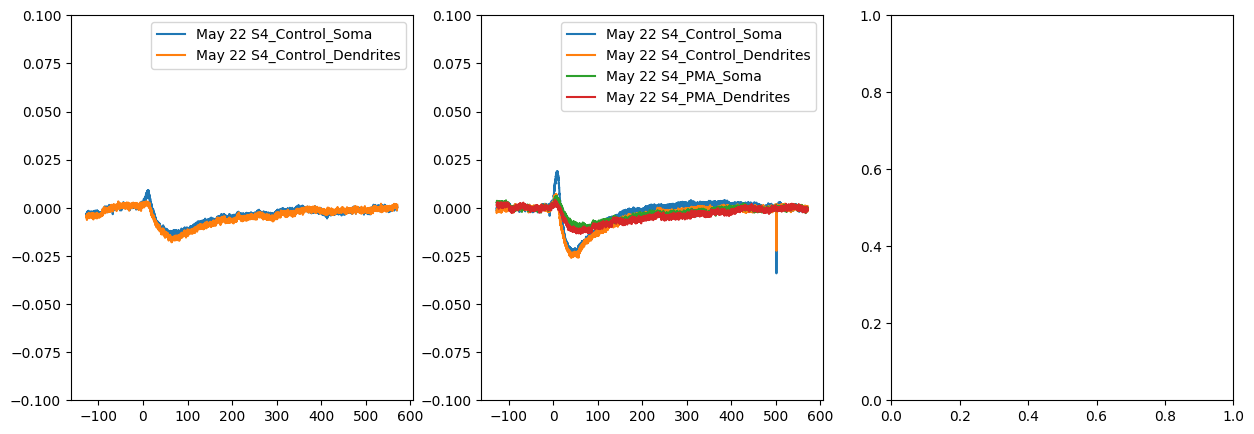

In [10]:

for k,v in time_value_dict.items():
    df_val = v['values'].copy()
    df_time = v['time'].copy()
    fig,ax=plt.subplots(1,3,figsize=[15,5])
    for c in df_val.columns:
        if 'Glucose' in c[2]:
            # try:
            if '10Hz' in c[1]: axi=1
            if '5Hz' in c[1]: axi=0
            if '100Hz' in c[1]: axi=2
            trace = df_val[c]
            time = df_time[c]  

            '''bleach correction'''
            start_refs_bool = np.logical_and(time<-10,time>-100) #'keep inbetween'

            has_signal = abs(z_trans(trace))<5  # 'not out of range'
            has_sig_ind = np.arange(len(has_signal))[has_signal] #'convert to indicies'
            has_sig_ind = has_sig_ind[:-20] #'trim indicies'
            has_signal = np.zeros_like(has_signal) #'init new bool array'
            has_signal[has_sig_ind] = True #'flip good inicies'
            trim_time = time[has_signal]
            end_refs_bool = np.logical_and(time>np.max(trim_time)-50,time<np.max(trim_time)) #'keep last 50s'
            ref_inds_bool = np.logical_or( start_refs_bool, end_refs_bool) #'keep both windows'
            try:
                ref_inds=np.arange(len(ref_inds_bool))[ref_inds_bool]
                trace,bc = bleach_cor(trace,ref_inds)
            except: print(ref_inds,time,k,c)


            '''DF calc'''
            df_refs =  np.logical_and(time<-10,time>-100)
            f0 = np.mean(trace[df_refs])
            df_trace = (trace-f0)/f0
            label = k+'_'+c[0]+'_'+c[3]
            ax[axi].plot(time[has_signal], df_trace[has_signal],label=label)
            ax[axi].legend()
            # ax.set_xlim(-3,None)
            ax[axi].set_ylim(-.1,.1)
            df_val[c] = df_trace
            # except: print(k,c)
    
    time_value_dict[k]['values']=df_val
    plt.show()
# plt.legend()

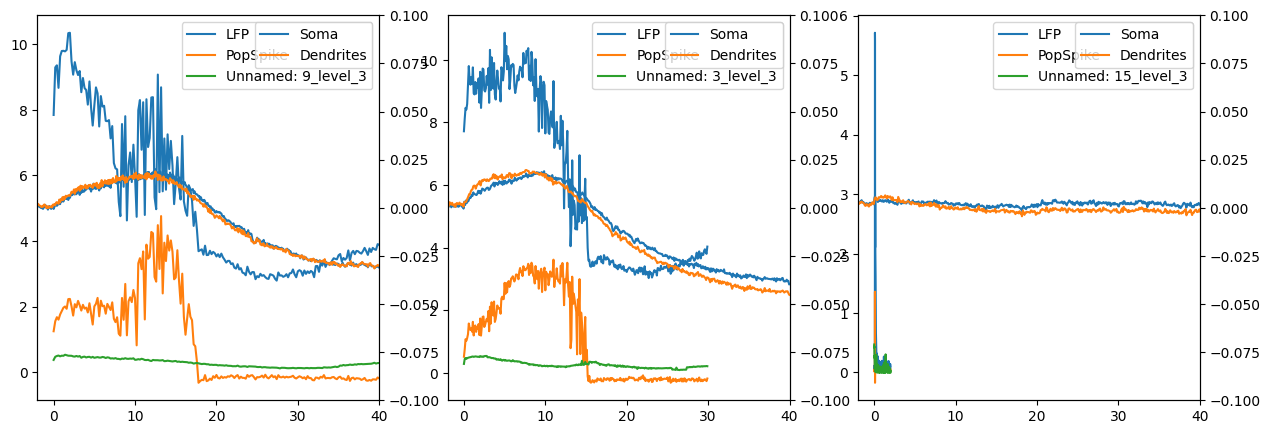

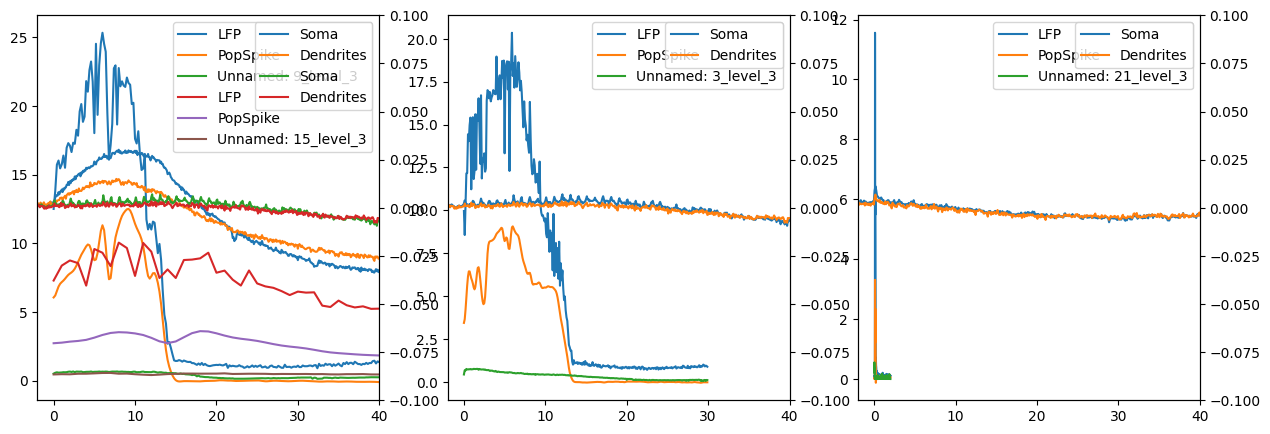

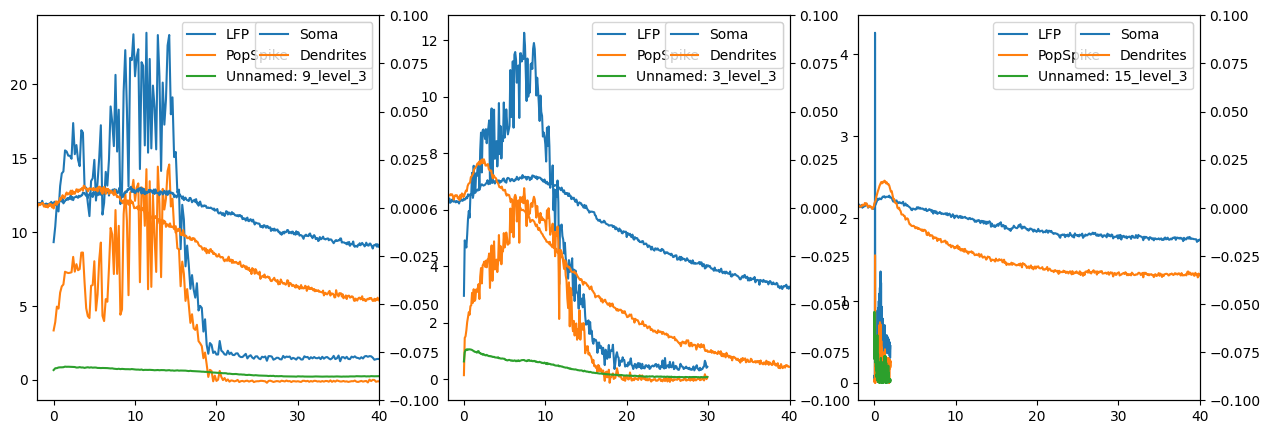

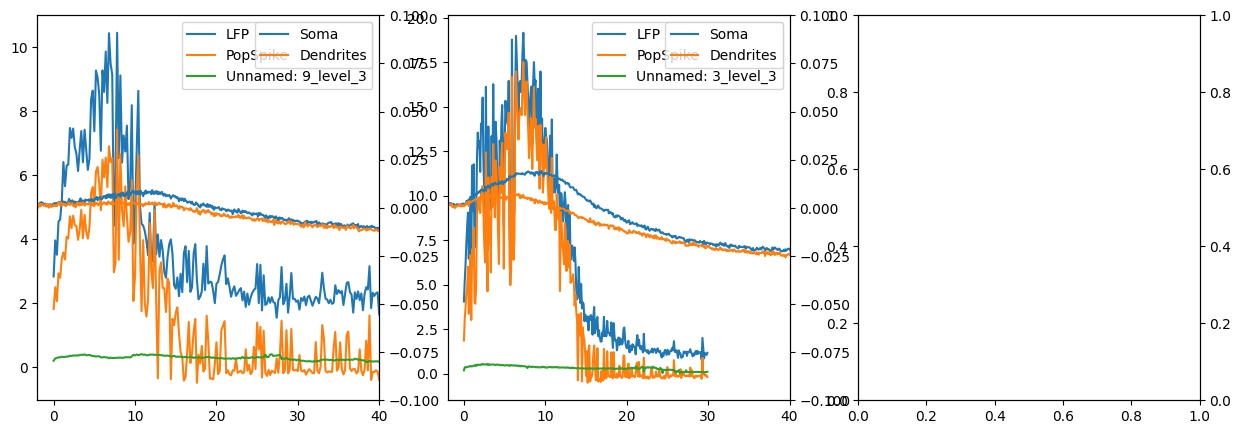

In [11]:
for k,v in time_value_dict.items():
    df_val = v['values'].copy()
    df_time = v['time'].copy()
    fig,ax=plt.subplots(1,3,figsize=[15,5])
    twix = [0,0,0]
    for axi in range(3):
            twix[axi] = ax[axi].twinx()
    for c in df_val.columns:
        if 'Control' in c[0]:
            if '10Hz' in c[1]: axi=1
            if '5Hz' in c[1]: axi=0
            if '100Hz' in c[1]: axi=2
            

            if 'Glucose' in c[2]:
                trace_v = df_val[c]
                trace_t = df_time[c]
                label = c[3]
                twix[axi].plot(trace_t, trace_v,label=label)                
                twix[axi].set_ylim(-.1,.1)
                twix[axi].legend()
            else:
                trace_v = df_val[c]
                trace_t = df_time[c]
                label = c[3]
                ax[axi].plot(trace_t, trace_v,label=label)
            
                # ax[axi].set_ylim(-.1,.1)
                ax[axi].set_xlim(-2,40)
                ax[axi].legend()

In [12]:


df_val = time_value_dict['May 22 S1']['values'].copy()
df_time = time_value_dict['May 22 S1']['time'].copy()



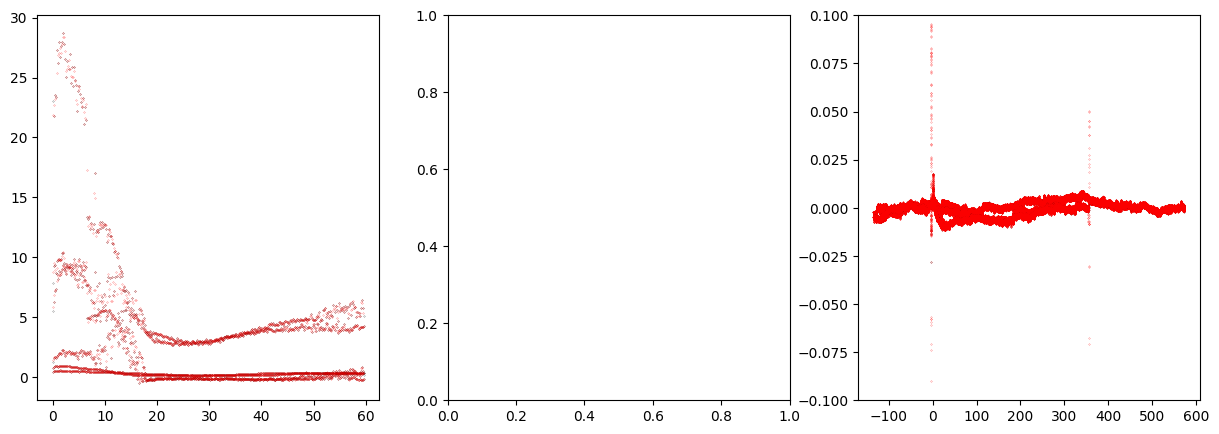

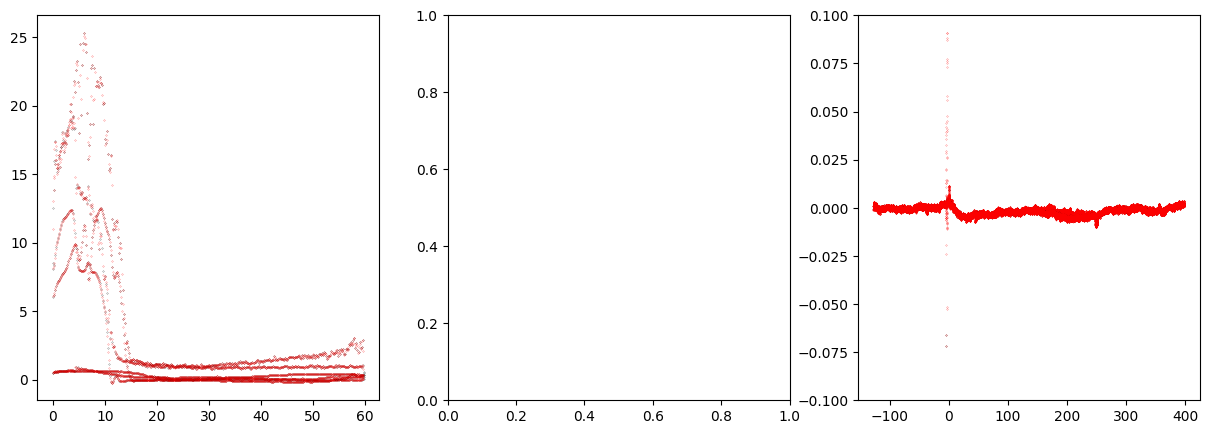

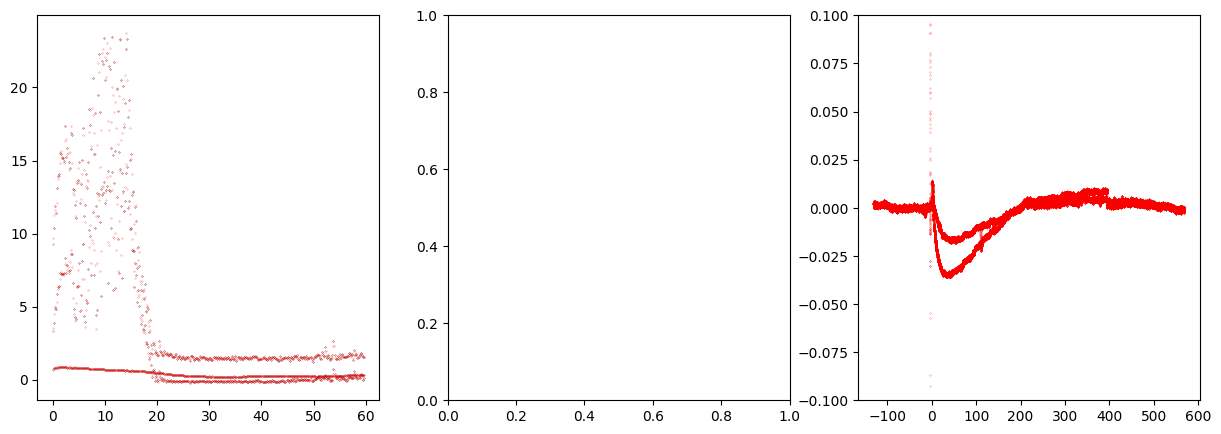

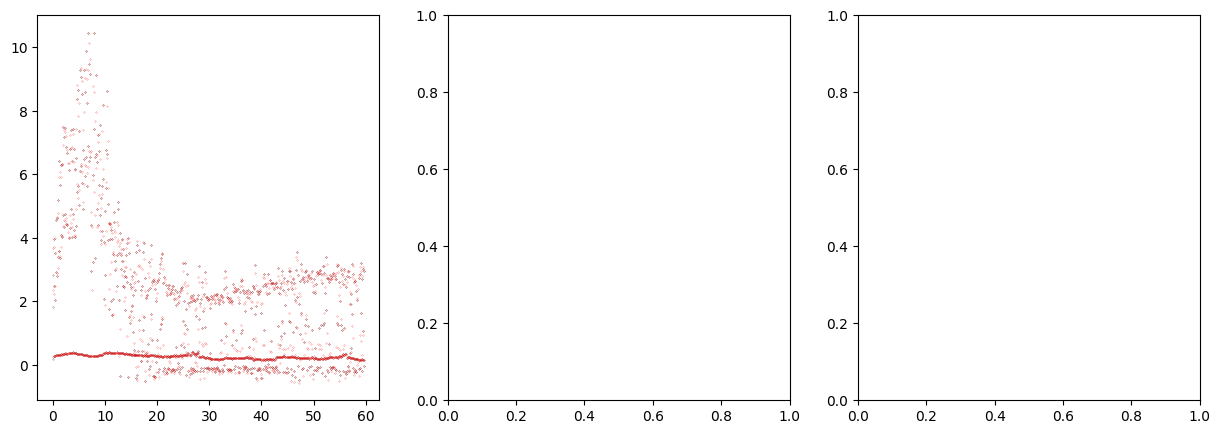

In [13]:
for k,v in time_value_dict.items():
    ups_val = v['values'].copy()
    ups_time = v['time'].copy()
    fig,ax=plt.subplots(1,3,figsize=[15,5])
    for c in ups_val.columns:
        if '10Hz' in c[1]: axi=1
        if '5Hz' in c[1]: axi=0
        if '100Hz' in c[1]: axi=2
        if '5Hz' in c[1] and ('Integrals' in c[2] or 'fEPSP' in c[2]):
            y_low = ups_val[c]
            x_low = ups_time[c]
            fs_high = 10
            fs_low = 5
            c_other = (c[0],c[1],'Glucose','Soma')
            x_high = ups_time[c_other]
            y_high, x_high = upsample(y_low,fs_low,fs_high,x_low=x_low,x_high=x_high,kind='quadratic')

            if len(y_high)<len(ups_val):
                'nan fill'
                y_high = np.concatenate([y_high,np.ones(len(ups_val)-len(y_high))*np.nan])
                x_high = np.concatenate([x_high,np.ones(len(ups_val)-len(x_high))*np.nan])
            ax[axi].scatter(x_low,y_low,s=0.1,marker ='.',color='k')
            ax[axi].scatter(x_high,y_high,s=0.1,marker ='.',color='r')
            ups_val[c] = y_high
            ups_time[c] = x_high
        if '100Hz' in c[1] and 'Glucose' in c[2]:
            y_low = ups_val[c]
            x_low = ups_time[c]
            fs_high = 100
            fs_low = 10
            c_other = (c[0],c[1],'Integrals','LFP')
            x_high = ups_time[c_other]
            y_high, x_high = upsample(y_low,fs_low,fs_high,x_low=x_low,x_high=[],kind='quadratic')
            if len(x_high)>len(ups_val):
                'nan fill new dataframe'
                dl = len(x_high)-len(ups_val)
                new_ind = np.arange(dl)+len(ups_val)+1
                nan_pd = pd.DataFrame( data=np.nan*np.ones((dl,len(ups_val.columns))), index=new_ind, columns=ups_val.columns)
                ups_val = pd.concat([ups_val,nan_pd],axis =0,join='outer')
                ups_time = pd.concat([ups_time,nan_pd],axis =0,join='outer')
            if len(y_high)<len(ups_val):
                'nan fill new trace'
                y_high = np.concatenate([y_high,np.ones(len(ups_val)-len(y_high))*np.nan])
                x_high = np.concatenate([x_high,np.ones(len(ups_val)-len(x_high))*np.nan])
            ups_val[c] = y_high
            ups_time[c] = x_high
            ax[axi].scatter(x_low,y_low,s=0.1,marker ='.',color='k')
            ax[axi].scatter(x_high,y_high,s=0.1,marker ='.',color='r')
            ax[axi].set_ylim(-0.1,0.1)
    time_value_dict[k] = {'values':ups_val, 'time':ups_time}

In [ ]:
def blind_deconv(k,impulse_sig,target_sig,just_filter=True):
    import scipy
    import numpy as np
    def filter_conv(impulse_sig,filter):
        y = np.convolve(impulse_sig, filter, mode='full')
        return y[:]
    def err_func(filter,impulse_sig,target_sig):        
        yhat = filter_conv(impulse_sig,filter)
        plt.plot(target_sig,'k')
        plt.plot(yhat,'r')
        plt.show()
        return np.sum((yhat-target_sig)**2)

    if len(target_sig)>len(impulse_sig): k = len(target_sig) - len(impulse_sig) + 1
    init_filter = np.ones(k)

    opt_result = scipy.optimize.minimize(err_func, init_filter, args=(impulse_sig, target_sig))
    if just_filter: return opt_result['x']
    else: return opt_result


for k,v in time_value_dict.items():
    c_1 = ('Control', '10Hz', 'Glucose', 'Soma')
    c_2 = ('Control', '10Hz', 'Integrals', 'PopSpike')
    fig,ax=plt.subplots(1,3,figsize=(9,3)) #
    
    sig1 = v['values'][c_1]
    sig2 = v['values'][c_2]
    sig_1_t = v['time'][c_1]
    sig_2_t =v['time'][c_2]

    min_t = -3

    sig_1_t = sig_1_t[ v['time'][c_1]>=min_t ]
    sig1 = sig1[ v['time'][c_1]>=min_t ]
    sig_2_t = sig_2_t[ v['time'][c_2]>=min_t ]
    sig2 = sig2[ v['time'][c_2]>=min_t ]

    sig_1_t = sig_1_t[np.logical_not(np.isnan(sig1))]
    sig_2_t = sig_2_t[np.logical_not(np.isnan(sig2))]

    sig1 = sig1[np.logical_not(np.isnan(sig1))]
    sig2 = sig2[np.logical_not(np.isnan(sig2))]


    filter = blind_deconv(len(sig2),impulse_sig=sig2,target_sig=sig1)

    ax[1].plot(sig_1_t,z_trans(sig1))
    ax[1].plot(sig_2_t,z_trans(sig2))
    # ax[1].plot(sig_2_t[:len(filter)],filter)
    plt.show()
    break

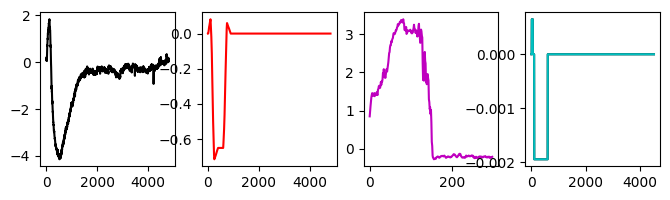

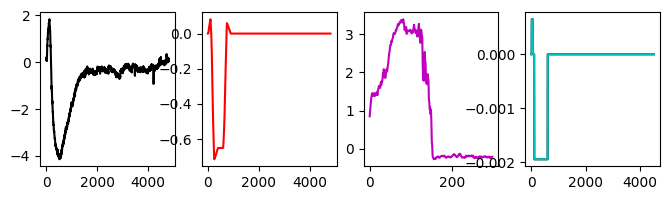

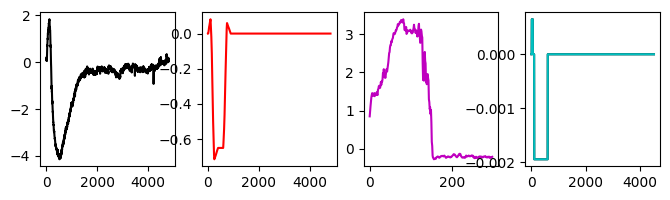

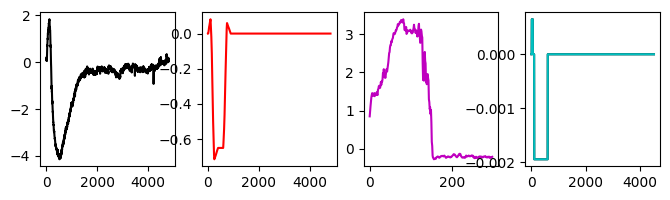

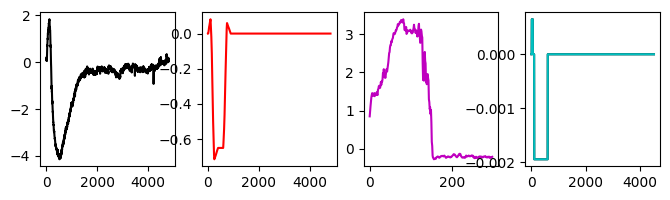

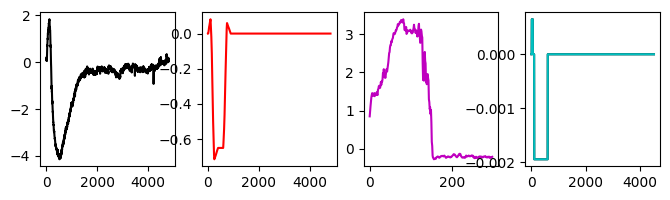

KeyboardInterrupt: ignored

In [56]:
def filter_conv(filter,impulse_sig):
    y = np.convolve(filter,  impulse_sig,  mode='full')
    return y[:]

def blind_deconv(k,impulse_sig,target_sig,just_filter=True,init_filter=[],method='L-BFGS-B'):
    import scipy
    import numpy as np

    def err_func(filter,impulse_sig,target_sig,init_filter):        
        yhat = filter_conv(filter,impulse_sig)
        fig,ax=plt.subplots(1,4,figsize=(8,2))
        ax[0].plot(target_sig,'k',label='target_sig')
        ax[1].plot(yhat,'r',label='yhat')
        ax[2].plot(impulse_sig,'m',label='impulse_sig')
        ax[3].plot(filter,'k',label='hidden filter')
        ax[3].plot(init_filter,'c',label='initial filter')
        plt.show()
        error = np.sum((yhat-target_sig)**2)
        return error

    if len(target_sig)>len(impulse_sig): k = len(target_sig) - len(impulse_sig) + 1
    if len(init_filter)==0: init_filter = np.zeros(k)
    filter = init_filter
    opt_result = scipy.optimize.minimize(err_func, filter, args=(impulse_sig, target_sig,init_filter))
    if just_filter: return opt_result['x']
    else: return opt_result

c_1 = ('Control', '10Hz', 'Glucose', 'Soma')
c_2 = ('Control', '10Hz', 'Integrals', 'PopSpike')

sig1 = v['values'][c_1]*100
sig2 = v['values'][c_2]

min_t = -3

sig_1_t = sig_1_t[ v['time'][c_1]>=min_t ]
sig1 = sig1[ v['time'][c_1]>=min_t ]
sig_2_t = sig_2_t[ v['time'][c_2]>=min_t ]
sig2 = sig2[ v['time'][c_2]>=min_t ]


sig1 = np.array(sig1[np.logical_not(np.isnan(sig1))])
sig2 = np.array(sig2[np.logical_not(np.isnan(sig2))])

N= 4
sig1 = np.convolve(sig1, np.ones(N)/N, mode='valid')
sig2 = np.convolve(sig2, np.ones(N)/N, mode='valid')


init_filter = np.zeros(len(sig1[:-len(sig2)+1]))
init_filter[10:50] = .1
init_filter[100:600] = -.3
init_filter = init_filter/np.sum(abs(init_filter))
target = sig1
filter = blind_deconv(len(sig1),impulse_sig=sig2,target_sig=target,init_filter=init_filter)

In [ ]:
def filter_conv(impulse_sig,filter):
    y = np.convolve(impulse_sig, filter, mode='full')
    return y[:]


impulse_sig = sig2
target_sig = sig1


init_filter = np.ones(k)

target_sig_pad = np.concatenate([target_sig,np.zeros(len(init_filter))])
f_con = filter_conv(impulse_sig=impulse_sig, filter=init_filter) 


filter_conv

print('impulse_sig',len(impulse_sig))
print('init_filter',len(init_filter))
print('target_sig',len(target_sig))
print('target_sig_pad',len(target_sig_pad))
print('f_con',len(f_con))

In [ ]:
area_summary = {}
for k,v in time_value_dict.items():
    cols = v['values'].columns
    idx = index=['pos_area','neg_area','tot_area']
    area_df = pd.DataFrame(data=np.ones([len(idx),len(cols)])*np.nan,index=idx,columns=cols)
    for c in v['values'].columns:
        vals = z_trans(v['values'][c])
        time = v['time'][c]
        is_after = time>0
         
        is_pos = vals>0
        pos_include = np.logical_and(is_pos,is_after)
        pos_area = np.sum( vals[pos_include]*np.sum(pos_include)*np.diff(time[0:2])  )
        
        is_neg = vals<0
        neg_include = np.logical_and(is_neg,is_after)
        neg_area = np.sum( vals[neg_include]*np.sum(neg_include)*np.diff(time[0:2])  )

        area_df.at['pos_area',c] = pos_area
        area_df.at['neg_area',c] = neg_area
        area_df.at['tot_area',c] = pos_area + neg_area
    area_summary[k] = area_df


In [ ]:
df = area_summary[k]
df=pd.concat([v for k,v in area_summary.items()], axis=1, keys=area_summary.keys())



Soma_10 = []
LFP_10 = []
Pop_10 = []
fEPSP_10 = []
for c in df:
    # print(c)
    if 'Soma' in c[4] and '10Hz' in c[2]:
        Soma_10.append(df[c]['neg_area'])
    if 'LFP' in c[4] and '10Hz' in c[2]:
        LFP_10.append(df[c]['pos_area'])
    if 'Pop' in c[4] and '10Hz' in c[2]:
        Pop_10.append(df[c]['pos_area'])
    if 'fEPSP' in c[3] and '10Hz' in c[2]:
        fEPSP_10.append(df[c]['pos_area'])


fig,ax=plt.subplots(1,3,figsize=(9,3))
ax[0].scatter(LFP_10,Soma_10)
ax[1].scatter(Pop_10,Soma_10,)
ax[2].scatter(fEPSP_10,Soma_10,)

In [ ]:
'''
# Bleach Correct all Traces,
# Convert to dF/f
# Z-Score
Upsample
Cross corr 

'''

In [ ]:
test_m
